# Rectified Flow

TL;DR: This write-up contains the minimum essential concepts and simple code to understand flow models and rectified flow.

The original [Rectified Flow blog](https://www.cs.utexas.edu/~lqiang/rectflow/html/intro.html) by the paper’s authors is an excellent resource. This write-up extracts only the minimal information needed from their blog post for comprehension and complements them with more examples and details for high-level ideas. We also provide straightforward implementations and visualizations as we introduce the concepts. The readers are encouraged to read their blog and paper for more information.

The implementation is adapted from [this repo](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Flow_Straight_and_Fast_Learning_to_Generate_and_Transfer_Data_with_Rectified_Flow), which implements only 1-rectified flow. Additional implementation and visualization are provided to understand the "rewiring" process and k-rectified flow.

If you have any questions or notice any errors, please contact [Wenhan Gao](https://wenhangao21.github.io/).

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
device = 'cpu' # change to cpu if no cuda available
batch_size = 2048
dataset_size = 10_000
epochs = 2_000
wd = 0.01 # weight decay

## Problem Formulation

Given samples from two distributions $\pi_0$ and $\pi_1$, we aim to find a transport map $T$ such that, when $Z_0 \sim \pi_0$, then $Z_1 = T(Z_0) \sim \pi_1$.
- For image generation, $\pi_1$ can be the image data distribution and $\pi_0$ can be any prior distribution such as Gaussian.
- **Unlike diffusion models, we do not require any of the distributions to be Gaussian**.

Let's first collect samples from two distributions.

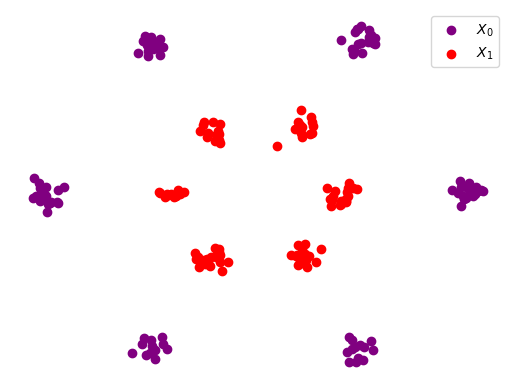

In [ ]:
def sample_multimodal_gaussian(modes, std, N=1000):
    """
    Generates samples from a multimodal distribution defined by the given modes.

    Each sample is generated by:
      1. Selecting a mode at random from the provided list of modes.
      2. Creating a random sample from a standard normal distribution (Gaussian noise).
      3. Offsetting the first two dimensions of the sample by the selected mode's coordinates.

    Parameters:
        modes (np.ndarray): An array of shape (n_modes, D) where each row defines the coordinates of a mode (cluster center).
        std (float): Standard deviation of the Gaussian noise added to each sample.
        N (int, optional): Number of samples to generate. Default is 1000.

    Returns:
        np.ndarray: A (N, D)-shaped array of samples.
    """
    dataset = []
    for i in range(N):
        sample = np.random.randn(modes.shape[1]) * std
        mode_idx = np.random.randint(modes.shape[0])
        sample[0] += modes[mode_idx, 0]
        sample[1] += modes[mode_idx, 1]
        dataset.append(sample)
    return np.array(dataset, dtype="float32")

def sample_pi(radius, N=1000):
  # The modes are six equidistant points on a circle of radius r.
  theta = np.array([0., 60, 120, 180, 240,  300]) / 360 * 2 * np.pi
  std = 0.5
  modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta), np.sin(theta))])
  pi_0 = sample_multimodal_gaussian(modes, std, N=N)
  return pi_0

pi_0 = sample_pi(radius=12, N=dataset_size)
pi_1 = sample_pi(radius=5, N=dataset_size)

# Display the samples
plt.figure()
plt.scatter(pi_0[::100, 0], pi_0[::100, 1], c='purple', label=r'$X_0$')
plt.scatter(pi_1[::100, 0], pi_1[::100, 1], c='red', label=r'$X_1$')
plt.legend(loc='upper right')
plt.axis('off')
plt.gca().set_frame_on(False)
plt.show()

## Transport Map: ODEs

In flow models, the mapping $T$ is implicitly defined by an ordinary differential equation (ODE):

$$
\frac{d}{d t} Z_t=v\left(Z_t, t\right), \quad Z_0 \sim \pi_0, \quad \forall t \in[0,1],
$$
where $v\left(Z_t, t\right)$ is called the velocity field.

- A key property to note here is that from the Picard–Lindelöf Theorem, if the vector field $v\left(Z_t, t\right)$ is Lipschitz continuous in $z$ and continuous in $t$, then the initial value problem has a unique solution for each initial condition. In other words, **the transport map $T$ is invertible and there is no crossing of trajectories**.

## Straight Line ODEs

There are infinitely many ways to define the vector field $v\left(Z_t, t\right)$.
- In particular, **we aim to regularize $v\left(Z_t, t\right)$ so that the trajectories $Z_t$ evolve as close to straight lines as possible**, since straight-line trajectories require less steps during sampling (think about solving ODEs by forward Euler).
- Rectified flow works by finding an ODE to match (the marginal distributions of) the linear intepolation of points from $\pi_0$ and $\pi_1$.

Assume we observe $X_0 \sim \pi_0$ and $X_1 \sim \pi_1$. Let $X_t$ for $\forall t \in[0,1]$ be the linear interpolation of $X_0$ and $X_1$:
$$
X_t=t X_1+(1-t) X_0, \quad t \in[0,1].
$$
Taking derivatives with respect to $t$, we have an "ODE":
$$
\frac{d}{d t} X_t=X_1-X_0, \quad \forall t \in[0,1] .
$$

**Samples $X_0$ and $X_1$ are randomly paired, and this pairing is fixed for training (we will revisit this later for a better pairing).**

In [ ]:
# For training purposes, we load the sample to a dataloader. This creates a fixed pairing between X_0 and X_1.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1 = dist1
        self.dist2 = dist2
        assert self.dist1.shape == self.dist2.shape

    def __len__(self):
        return self.dist1.shape[0]

    def __getitem__(self, idx):
        return self.dist1[idx], self.dist2[idx]

dataset = Dataset(pi_0, pi_1)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Let's visualize some of the pairings.



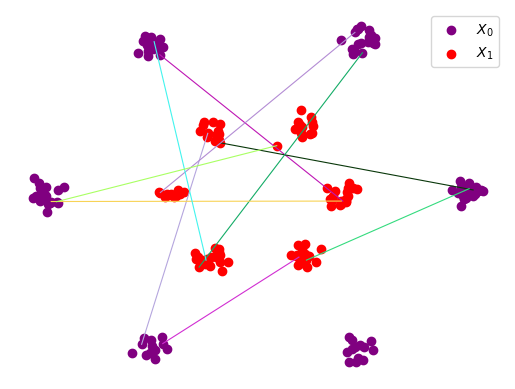

In [ ]:
def visualize_pairings(pi_0, pi_1):
    """
    Visualizes paired samples from two distributions π₀ and π₁.

    Parameters:
    -----------
    pi_0 : ndarray of shape (N, 2)
        Samples from the source distribution π₀.

    pi_1 : ndarray of shape (N, 2)
        Samples from the target distribution π₁, assumed to be paired with pi_0.

    Description:
    ------------
    - Plots every 100th samples from π₀ in purple and from π₁ in red.
    - Draws lines between every 1000th pair, using randomly generated RGB colors for each line to visualize pairing diversity.
    """
    plt.figure()
    plt.scatter(pi_0[::100, 0], pi_0[::100, 1], c='purple', label=r'$X_0$')
    plt.scatter(pi_1[::100, 0], pi_1[::100, 1], c='red', label=r'$X_1$')
    for i in range(0, pi_0.shape[0], 1000):
        color = np.random.rand(3,)  # Random RGB color
        plt.plot(
            [pi_0[i, 0], pi_1[i, 0]],
            [pi_0[i, 1], pi_1[i, 1]],
            color=color, linewidth=0.8
        )
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.gca().set_frame_on(False)
    plt.show()
visualize_pairings(pi_0, pi_1)


## Casualization

It is important to note that the ODE above is not **causal** (i.e., forward-simulatable), as $X_t$ depends on the final state $X_1$.  
- In other words, given samples $X_0$ from $\pi_0$, we still cannot generate samples $X_1$ from the target distribution $\pi_1$.


To resolve the causality issue, we learn a velocity field $v\left(Z_t, t\right)$ such that the forward-simulatable ODE $\frac{d}{d t} Z_t=v\left(Z_t, t\right)$ can approximate the previous non-forward-simulatable process as closely as possible.

The simplest way to do this is to optimize $v$ to minimize the squared error between the two systems' velocity fields, namely $v$ and $X_1-X_0$:

$$
\min _v \int_0^1 \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1}\left[\left\|\left(X_1-X_0\right)-v\left(X_t, t\right)\right\|^2\right] d t, \quad \text { where } X_t=t X_1+(1-t) X_0.
$$
We can parameterize $v$ as a neural network and optimize it.

Let's parameterize $v$ and optimize it.

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, context_dim, h, out_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.Tanh(),
                                     nn.Linear(h, h), nn.Tanh(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, context):
        return self.network(torch.cat((x, context), dim=1))

def train_rectified_flow(rectified_flow, optimizer, train_dataloader, epochs, eps=1e-15):
    """
    Trains a rectified flow model to learn velocity fields between point pairs.

    For each batch, the function:
    - Randomly samples an interpolation time t ∈ [0, 1]
    - Computes the interpolated point x_t = (1 - t) * x0 + t * x1
    - Trains the model to predict the volecity (x1 - x0) at x_t and time t

    Args:
        rectified_flow (nn.Module): The neural network model representing the velocity field.
        optimizer (torch.optim.Optimizer): Optimizer used for training.
        train_dataloader (DataLoader): DataLoader providing (x0, x1) training pairs.
        epochs (int): Number of training epochs.
        eps (float): Small constant for numerical stability (not used in current implementation).
    """
    for epoch in tqdm(range(epochs)):
        for x0, x1 in (train_dataloader):
            x0, x1 = x0.to(device), x1.to(device)
            t = torch.rand((x1.shape[0], 1), device=device) # randomly sample t
            x_t = t * x1 + (1.-t) * x0
            target = x1 - x0
            pred = rectified_flow(x_t, t)
            loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

rectified_flow = MLP(2, 1, 64, 2).to(device)
optimizer = torch.optim.Adam(rectified_flow.parameters(), lr=5e-3, weight_decay=wd)
training_loss = train_rectified_flow(rectified_flow, optimizer, train_dataloader, epochs, eps=1e-15)
torch.save(rectified_flow.state_dict(), '1-rectified_flow.pth')

100%|██████████| 2000/2000 [04:04<00:00,  8.17it/s]


In [ ]:
# rectified_flow.load_state_dict(torch.load('1-rectified_flow.pth'))

Once the velocity field $v_\theta\left(Z_t, t\right)$ is learned, we can simulate samples from $\pi_1$ given samples from $\pi_0$ by solving the forward ODE:
$$
\frac{d}{d t} Z_t=v\left(Z_t, t\right), \quad Z_0 \sim \pi_0, \quad \forall t \in[0,1]
$$
by setting $Z_0 = X_0$. One way to solve it is using the [forward Euler method](https://en.wikipedia.org/wiki/Euler_method):

$$Z_{t+\Delta t}=Z_t+\Delta t \cdot v\left(Z_t, t\right),$$
where $\Delta t = \frac{1}{T}$ with T being the number of steps used in sampling. The straighter the trajectories are, the fewer steps are needed to achieve numerical precision.

Let's sample from $\pi_1$.

100%|██████████| 999/999 [00:13<00:00, 75.91it/s]


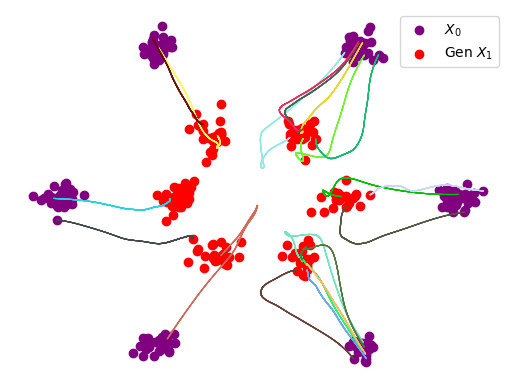

In [ ]:
def sample(flow_model, T, pi_0):
    """
    Simulates the forward flow trajectory starting from pi_0 using the learned velocity field.

    This function performs forward Euler over T discrete time steps to generate the trajectory
    of each point in pi_0 according to the velocity predicted by the flow_model.

    Args:
        flow_model (nn.Module): The trained rectified flow model that predicts velocity vectors.
        T (int): Number of time steps for forward Euler.
        pi_0 (torch.Tensor): Initial samples.

    Returns:
        torch.Tensor: A tensor of shape containing the full trajectory with T+1 steps for each point over time.
    """
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        drift_pred = flow_model(samples[-1].squeeze(0), t)
        samples.append((samples[-1] + drift_pred * 1. / T)) # intermedia Z_t stored for visualization purposes
    return torch.cat(samples)

def visualize_sampling(flow_model):
    """
    Visualizes the sampling trajectory of the flow model.

    This function:
    - Samples X_0.
    - Evolves these points forward using the flow model over 1000 steps.
    - Plots X_0, generated X_1, and a subset of intermediate trajectories.

    Args:
        flow_model (nn.Module): A trained flow model used to simulate particle movement.
    """
    test_pi_0 = sample_pi(radius=12, N=200)
    test_pi_1 = sample(flow_model=flow_model, T=1000, pi_0=torch.from_numpy(test_pi_0).to(device))
    plt.figure()
    plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], c='purple', label=r'$X_0$')
    plt.scatter(test_pi_1[-1, :, 0].data.cpu().numpy(),
                test_pi_1[-1, :, 1].data.cpu().numpy(), c='red', label=r'Gen $X_1$')
    num_trajs = test_pi_0.shape[0] // 10  # Number of trajectories to plot
    colors = [np.random.rand(3,) for _ in range(num_trajs)]  # One color per trajectory

    for i in tqdm(range(1, 1000)):
        for k, j in enumerate(range(0, test_pi_0.shape[0], 10)):
            plt.plot(
                [test_pi_1[i-1, j, 0].item(), test_pi_1[i, j, 0].item()],
                [test_pi_1[i-1, j, 1].item(), test_pi_1[i, j, 1].item()],
                linewidth=0.8,
                color=colors[k]
            )
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.gca().set_frame_on(False)
    plt.show()

visualize_sampling(rectified_flow)

## ReFlow

It can be seen that the **learned trajectories are not straight lines**, even though the learning objective is based on straight-line pairings.  
- This is due to the causal ODE formulation, which prohibits trajectory crossings. However, the random pairing introduces many crossings.  
- While the velocity field for each individual path is a straight line by construction, the neural network learns a single velocity field that represents the **mean volecity** across all paths.  
  - To understand this, consider the crossing points: **at those intersections, the network minimizes the MSE objective by learning the average velocity, rather than preserving the true velocity of each path**. Although it happens not just at the points of crossings due to certain regularity conditions of the neural networks.


Let's visualize this by having $X_0=\{(0,0),(0,1)\}, \quad X_1=\{(1,1),(1,0)\}$ with a crossing as the initial pairing.

- The learned trajectory will attempt to interpolate between **all** the points in $X_0$ and $X_1$ by discovering smooth and non-intersecting paths that minimize transport distortion, effectively **learning to "rectify" the pairing and follow a more natural direction**.
- The paper author provide justifications via optimal transport theory in their paper.
- You may need to run the simulation multiple times to obtain flow samples that are close to the real samples. This is because the model is trained on only two point pairs, leaving large regions of the space where the velocity field is poorly learned.

100%|██████████| 1000/1000 [00:02<00:00, 392.40it/s]


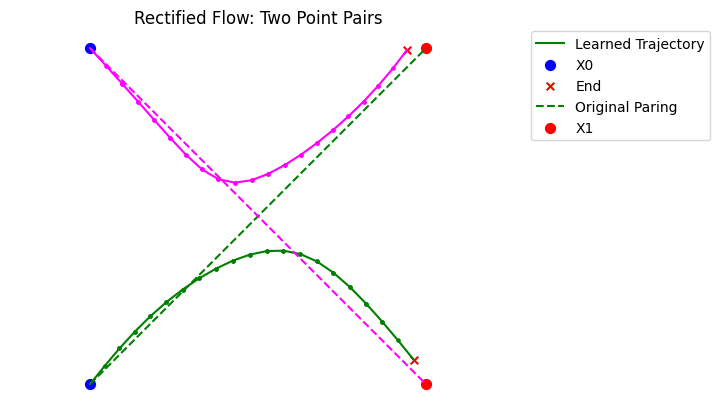

In [ ]:
def visualize_velocity_learning():
    """
    This block is for concept illustration only and unrelated to the rest of the code.
    """
    # Two point pairs: (0,0)→(1,1) and (0,1)→(1,0)
    pi_0, pi_1 = np.array([[0., 0.], [0., 1.]], dtype="float32"), np.array([[1., 1.], [1., 0.]], dtype="float32")
    pi_0_tensor, pi_1_tensor = torch.tensor(pi_0).to(device), torch.tensor(pi_1).to(device)

    # Train the flow model
    rectified_flow = MLP(2, 1, 64, 2).to(device)
    optimizer = torch.optim.Adam(rectified_flow.parameters(), lr=3e-3, weight_decay=0.01)
    dataset = Dataset(pi_0_tensor, pi_1_tensor)
    train_dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)
    train_rectified_flow(rectified_flow, optimizer, train_dataloader, epochs=1000)
    # Samplle
    traj = sample(rectified_flow, T=100, pi_0=pi_0_tensor).detach().cpu().numpy()
    # Visualize
    plt.figure()
    for i in range(2):
        point_indices = list(range(0, traj.shape[0] - 1, 5)) + [traj.shape[0] - 1]
        color = 'green' if i == 0 else 'magenta'
        for k in range(len(point_indices) - 1):
            x0, y0 = traj[point_indices[k]][i]
            x1, y1 = traj[point_indices[k + 1]][i]
            plt.plot([x0, x1], [y0, y1], c=color, label="Learned Trajectory" if k == 0 and i == 0 else None)
            if k == 0:
                plt.scatter([x0], [y0], s=50, c='blue', label="X0" if i == 0 else None)
            elif k + 1 == len(point_indices) - 1:
                plt.scatter([x1], [y1], s=30, c='red', marker='x', label="End" if i == 0 else None)
            else:
                plt.scatter([x0], [y0], s=5, c=color)
                plt.scatter([x1], [y1], s=5, c=color)

        x0_gt, x1_gt = pi_0[i], pi_1[i]
        plt.plot([x0_gt[0], x1_gt[0]], [x0_gt[1], x1_gt[1]], linestyle='--', c=color, label="Original Paring" if i == 0 else None)
        plt.scatter(*x1_gt, s=50, c='red', label="X1" if i == 0 else None)

    plt.title("Rectified Flow: Two Point Pairs")
    plt.axis("equal")
    plt.axis('off')
    plt.gca().set_frame_on(False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


visualize_velocity_learning()

Since the flow model needs to reorganize paths at the intersection of straight-line trajectories, the resulting flow still produces curved trajectories.
- If we have a pairing that does not have crossings (or less crossings), the model can learn straight trajectories.
- We notice that the "pairs" produced by the flow model are better matched with reduced number of trajectory crossings in their linear interpolations.

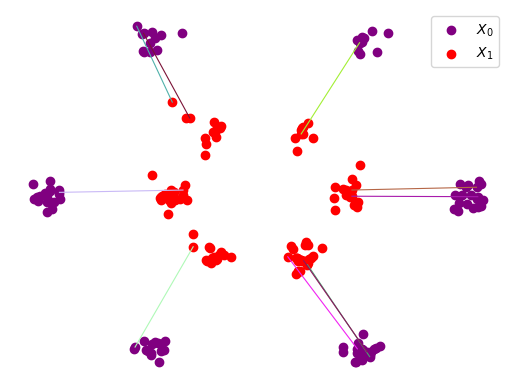

In [ ]:
# Get X_1 from 1-Rectified flow. You can use the same X_0 or resample.
# pi_0_flow2 = pi_0.copy()
pi_0_flow2 = sample_pi(radius=12, N=dataset_size)
traj_flow2 = sample(rectified_flow, T=1000, pi_0=torch.from_numpy(pi_0_flow2).to(device))
pi_1_flow2 = traj_flow2[-1].clone().cpu().detach().numpy()

visualize_pairings(pi_0_flow2, pi_1_flow2)

To further straighten the flow, the authors propose to "reflow".
- Suppose we sample a batch $X_0$ from $\pi_0$. Then, starting from $X_0$, we simulate the previously learned flow (referred to as the 1-Rectified Flow) to obtain $X_1=\operatorname{Flow}_1\left(X_0\right)$
- We use these newly generated pairs ( $X_0, X_1$ ) to train a new flow, called the 2-Rectified Flow, by solving the following objective:

$$
\min _v \int_0^1 \mathbb{E}_{X_0 \sim \pi_0, X_1=\operatorname{Flow}_1\left(X_0\right)}\left[\left\|\left(X_1-X_0\right)-v\left(X_t, t\right)\right\|^2\right] d t, \quad \text { with } \quad X_t=t X_1+(1-t) X_0
$$


Here, the only difference between the 2-Rectified Flow and the 1-Rectified Flow during training lies in the data pairing:
- In 1-Rectified Flow, $X_0$ and $X_1$ are randomly or arbitrarily paired.
- In 2-Rectified Flow, $X_0$ and $X_1$ are paired using the learned mapping from 1-Rectified Flow.

Let's trained a 2-Rectified Flow model.

In [ ]:
dataset_flow2 = Dataset(pi_0_flow2, pi_1_flow2)
dataloader_flow2 = DataLoader(dataset_flow2, batch_size=batch_size, shuffle=True, num_workers=0)
rectified_flow2 = MLP(2, 1, 64, 2).to(device)
rectified_flow2 = copy.deepcopy(rectified_flow) # we fine-tune the model from 1-Rectified Flow for faster training.
optimizer = torch.optim.Adam(rectified_flow2.parameters(), lr=5e-3, weight_decay=wd)
training_loss = train_rectified_flow(rectified_flow2, optimizer, dataloader_flow2, epochs, eps=1e-15)
torch.save(rectified_flow2.state_dict(), '2-rectified_flow.pth')

100%|██████████| 2000/2000 [05:13<00:00,  6.37it/s]


100%|██████████| 999/999 [00:13<00:00, 74.10it/s] 


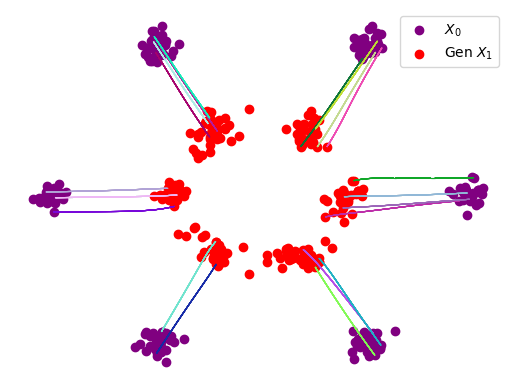

In [ ]:
visualize_sampling(rectified_flow2)